# Variational Autoencoder

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5, Loss: 276.1416


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5, Loss: 251.5844


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5, Loss: 246.9763


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5, Loss: 244.4543


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5, Loss: 243.1257


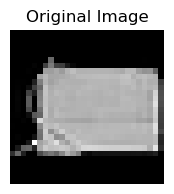

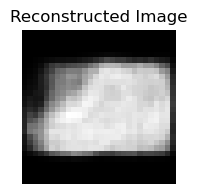

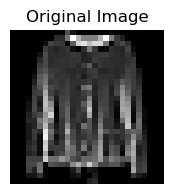

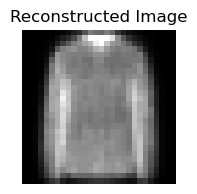

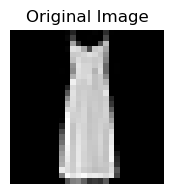

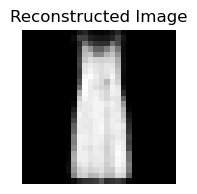

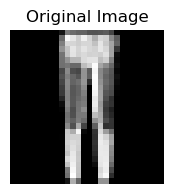

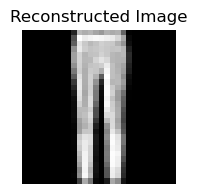

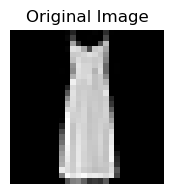

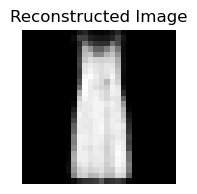

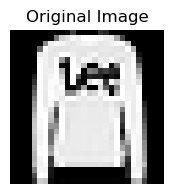

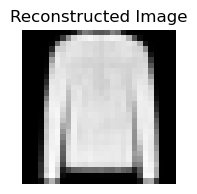

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# =======================
# 1. Device Configuration
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =======================
# 2. Data Loading (MNIST)
# =======================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten images to 1D (784,)
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# =======================
# 3. VAE Model Definition
# =======================
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(64, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(64, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()  # Output pixels (0 to 1)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Instantiate model
latent_dim = 20
model = VariationalAutoencoder(latent_dim).to(device)

# =======================
# 4. Training Loop
# =======================
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

for epoch in tqdm(range(epochs)):
    model.train()
    total_loss = 0

    for img, _ in tqdm(train_dataloader, leave=False):
        img = img.to(device)  # Move images to device
        
        optimizer.zero_grad()
        y_rec, y_mu, y_logvar = model(img)

        # Reconstruction Loss (BCE)
        recon_loss = F.binary_cross_entropy(y_rec, img, reduction="sum")

        # KL Divergence Loss
        kl_loss = -0.5 * torch.sum(1 + y_logvar - y_mu.pow(2) - y_logvar.exp())

        # Total Loss
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader.dataset)  # Normalize by dataset size
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# =======================
# 5. Testing & Visualization
# =======================
model.eval()
with torch.no_grad():
    img, _ = next(iter(test_dataloader))  # Get a batch of test images
    img = img.to(device)
    reconstructed, _, _ = model(img)

# Reshape images back to (28, 28)
img = img.cpu().view(-1, 28, 28)
reconstructed = reconstructed.cpu().view(-1, 28, 28)

# Plot original and reconstructed images
for i in range(6):
    random_idx = torch.randint(0, img.shape[0], size=[1]).item()
    
    # Original image
    plt.figure(figsize=(2, 2))
    plt.imshow(img[random_idx], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # Reconstructed image
    plt.figure(figsize=(2, 2))
    plt.imshow(reconstructed[random_idx], cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.show()
